<a href="https://colab.research.google.com/github/DiegoMBrito/Sprint_2/blob/main/Deep_Learning/jupiternotebook/MVP_Sprint2_DP_Diego_Brito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Definição do projeto de Deep Learning

 Este projeto tem como foco a Classificação de amostras geológicas por meio de imagens utilizando o modelos de aprendizado de máquina. O objetivo principal deste notebook é criar um modelo de visão computacional que consiga classificar uma imagem dentre essas categorias. Assim como avaliar a eficácia e precisão das redes neurais utilizdas (CNN, Resnet50 e InceptionV3) na identificação de diferentes tipos de estruturas contidas em rochas.

 Os dados desse projeto foram extraídas do site Kaggle, fonte: https://www.kaggle.com/datasets/mariasilvanaalvear04/estructuras-geologicas

 Este dataset é composto por 1.805 imagens dividadas em 9 tipos de estruturas geológicas encontradas nas rochas ígneas, sedimentares e metamorficas.
 Essas estruturas estão classificadas como Augen, Coluna Basaltica, Croncreção, Dique, Estratificação Cruzada, Pillow Lava, Dobras e Marcas de Ondas.
 Todo o dataset está separado em:
 - conjunto de treino, contendo 145 amostras em cada classe;
 - conjunto de  validação, contendo 50 amostras em cada classe e;
 -  conjunto de teste, contendo 15 amostras em cada classe.

## 1. Importando e instalando algumas bibliotecas necessárias para executação deste notebook.

In [ ]:
! pip install tensorflow

! pip install keras

! pip install pandas

! pip install scikit-learn

! pip install wget

In [ ]:
# Importações de libs necessárias

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import wget
import zipfile
import requests
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras import regularizers

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import layers, models, metrics
from tensorflow.keras import backend as K

from PIL import Image

## 2. Baixando e tratando os dados que serão usados como entrada para os modelos de Deep Learning.

In [ ]:
# Especifica a URL do arquivo ZIP contendo o diretório das imagens
url = 'https://raw.githubusercontent.com/DiegoMBrito/MVP_Sprint2/main/DP/data/Classes_Structures.zip'

# Baixa o arquivo ZIP
wget.download(url, 'Classes_Structures.zip')

# Extrai o arquivo ZIP
with zipfile.ZipFile('Classes_Structures.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
# Defini caminhos dos diretórios de treino, validação e teste que estão no github
diretorio_treino = 'Classes_Structures/Train'
diretorio_validacao = 'Classes_Structures/Validation'
diretorio_teste = 'Classes_Structures/Test'

In [ ]:
# Defini o tamanho das imagens e o número de classes
input_shape = (256, 256, 3)
num_classes = 9

In [ ]:
# Defini os hiperparâmetros do treinamento
batch_size = 128
epochs = 100

##### Preparação dos dados usando o 'ImageDataGenerator'

Que é uma classe da biblioteca Keras que permite gerar lotes de imagens aumentadas (augmented images) em tempo real durante o treinamento de modelos de aprendizado profundo. O objetivo principal do 'ImageDataGenerator' é aumentar a quantidade de dados de treinamento disponíveis, melhorando a capacidade de generalização do modelo e reduzindo o risco de overfitting. O aumento de dados envolve a aplicação de transformações aleatórias nas imagens existentes, como rotação, translação, zoom, espelhamento horizontal, alteração de brilho, entre outras técnicas.

In [ ]:
# Defini o data augmentation para imagens de treinamento
train_datagen = ImageDataGenerator(
    rescale=1.0/255, # Normalização
    rotation_range=40, # Rotação aleatória de até 40 graus
    width_shift_range=0.2, # Deslocamento horizontal aleatório
    height_shift_range=0.2, # Deslocamento vertical aleatório
    shear_range=0.2, # Cisalhamento aleatório
    zoom_range=0.2, # Zoom aleatório
    horizontal_flip=True, # Espelhamento horizontal aleatório
    fill_mode='nearest' # Modo de preenchimento)
    )


# Usa o ImageDataGenerator normal (sem data augmentation) para imagens de validação e teste
validation_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen = ImageDataGenerator(rescale=1.0/255)


In [ ]:
# Defini o gerador de dados para as imagens de treinamento
train_generator = train_datagen.flow_from_directory(
    diretorio_treino,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    diretorio_validacao,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    diretorio_teste,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1310 images belonging to 9 classes.
Found 360 images belonging to 9 classes.
Found 135 images belonging to 9 classes.


## 3.  Configuração dos modelos de Deep Learning

Será realizado o treinamento com 3 modelos diferentes, a CNN Profunda, Resnet50 e InceptionV3. O modelo com o melhor resultado de acurácia será usado para classificar as imagens de teste.

Como vou usar métricas iguais nos 3 meodelos, vou criar uma função chamada f1_score para facilitar a montagem do notebook.

Da mesma forma que as métricas, vou criar uma função chamada train_model para usar no modelos.

In [ ]:
# Função para calcular a f1_score nos modelos que serão treinados

def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    true_positives = tf.reduce_sum(y_true * y_pred)
    possible_positives = tf.reduce_sum(y_true)
    predicted_positives = tf.reduce_sum(y_pred)

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())

    f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1_score

In [ ]:
# Função para treinar os modelos com as métricas desejadas

def train_model(model, train_generator, validation_generator, metrics, epochs):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size
    )

    return history

### Modelo CNN Profunda

Aqui é especificada uma camada convolucional 2D que possui 32 filtros no inicio, sobe até 256 e volta para 32, um tamanho de filtro de 3x3 que usa a função de ativação ReLU. O parâmetro input_shape define a forma das imagens de entrada para a rede. Na sequência são adicionadas camadas max-pooling 2X2 com a mesma função de ativação. Também foi adicionado uma taxa Dropout com valor de 0.25. Para finalizar a rede, estou usando a função Softmax.

In [ ]:
# Carrega o modelo CNN Profunda e adicionar as camadas personalizadas

cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(input_shape)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu',))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu',))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(256, (3, 3), activation='relu',))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu',))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu',))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(32, activation='relu',))
tf.keras.layers.Dropout(0.25),
cnn_model.add(Dense(num_classes, activation='softmax'))

 O método summary() é usado para exibir um resumo da arquitetura do modelo de rede neural. Ele fornece uma representação compacta das camadas do modelo e seus parâmetros, incluindo o número de parâmetros treináveis e a forma de saída de cada camada.

In [ ]:
# Exibi o resumo do modelo
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

## 3.1 Treinamento do modelo CNN Profunda

Nesse modelo foi usado o otimizador Adam; com uma taxa de aprendizado de 0.001; para a função de perda, foi escolhida a função Categorical_crossentropy; e como métrica foi específicado a Acurácia.

In [ ]:
# Compila o modelo CNN com o otimizador Adam configurado com a taxa de aprendizado e métricas
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',
                  metrics=['accuracy', Recall(), f1_score])


In [ ]:
# Cria o callback para visualização das imagens durante o treinamento
tensorboard_callback = TensorBoard(log_dir='./logs')

In [ ]:
# NÃO recomendo ser executada, pois vai demorar muito o treinamento e o modelo já está treinado e salvo.

model = cnn_model  # Cria o modelo deep CNN

cnn_model_metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1_score] # Usa as métricas desejadas

history_cnn = train_model(cnn_model, train_generator, validation_generator, cnn_model_metrics, epochs) # Treina o modelo


Epoch 1/100
10/10 [==============================] - 11s 1s/step - loss: 2.2040 - accuracy: 0.1176 - precision: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.1108 - val_loss: 2.1828 - val_accuracy: 0.1562 - val_precision: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.1127
Epoch 2/100
10/10 [==============================] - 9s 903ms/step - loss: 2.1964 - accuracy: 0.1125 - precision: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.1112 - val_loss: 2.1736 - val_accuracy: 0.1797 - val_precision: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.1138
Epoch 3/100
10/10 [==============================] - 10s 948ms/step - loss: 2.1766 - accuracy: 0.1172 - precision: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.1142 - val_loss: 2.0442 - val_accuracy: 0.2539 - val_precision: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.1366
Epoch 4/100
10/10 [==============================] - 9s 863ms/step - loss: 2.1444 - accuracy: 0.1734 - precision: 0.0000e+00 - recall_1: 0.0

Visualização dos gráficos com resultados da acurácia e perda do modelo para o conjunto de treino e validação.

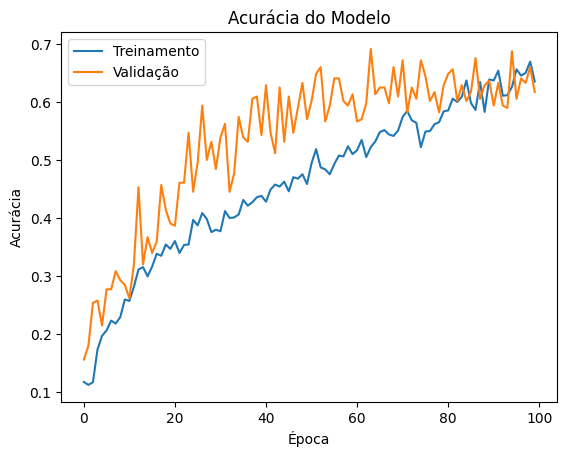

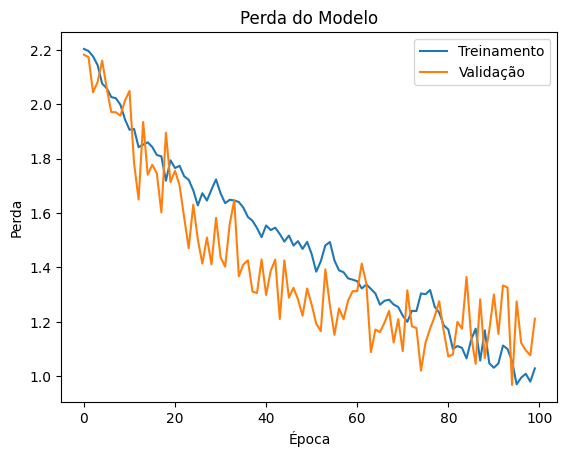

In [ ]:
# Plota a acurácia e a perda durante o treinamento do modelo CNN Profunda
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()

plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.show()

In [ ]:
# Prever as classes do conjunto de teste
y_true = test_generator.classes
y_pred = np.argmax(cnn_model.predict(test_generator), axis=-1)

2/2 [==============================] - 0s 61ms/step


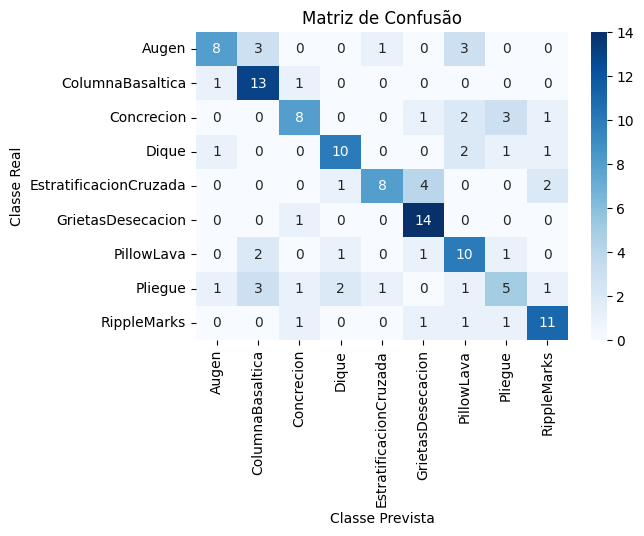

In [ ]:
# Calcula a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)

# Obtem rótulos das classes
class_labels = list(test_generator.class_indices.keys())

# Plota a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

O resultado da matriz de confusão mostra que o modelo CNN não generalizou bem, pois ocorreram predições erradas em várias classes.

In [ ]:
# Avalia o modelo CNN Profunda no conjunto de teste
test_loss, test_accuracy, test_precision, test_recall, test_f1 = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

# Imprimir as métricas no conjunto de teste
print("Loss no conjunto de teste:", test_loss)
print("Acurácia no conjunto de teste:", test_accuracy)
print("Precisão no conjunto de teste:", test_precision)
print("Recall no conjunto de teste:", test_recall)
print("F1-score no conjunto de teste:", test_f1)

1/1 [==============================] - 0s 270ms/step - loss: 1.1387 - accuracy: 0.6328 - precision: 0.7529 - recall_1: 0.5000 - f1_score: 0.5212
Loss no conjunto de teste: 1.1387066841125488
Acurácia no conjunto de teste: 0.6328125
Precisão no conjunto de teste: 0.7529411911964417
Recall no conjunto de teste: 0.5
F1-score no conjunto de teste: 0.5212090611457825


O modelo CNN Profunda mostrou um resultado mediano para o conjunto de teste com acuária de 63,28%. Todas as métricas outras métricas estão em conformidade com o resultado da acurácia. O que nos mostra uma visão bastante ampla do desempenho do modelo.
Esse foi o melhor resultado encontrado mesmo variando as configurações dos hiperparãemtros do modelo.

In [ ]:
# Salvar o modelo Deep CNN
# model.save('D:/Pessoal/Estudos_Pessoais/Pos_Graduacao/Clone_GitHub/Sprint_2/Deep_Learning/Modelos_MVP_Final/cnn_model.h5')

### Modelo Resnet50

A configuração das camadas começa com a camada GlobalAveragePooling2D, passando para as camadas densas, começando com uma de 32 neurônios, aumentando até 512 e, diminuindo até 32 neurônios novamente para chegar próximo ao número de saída, 9 neurônios, representando cada uma das classes de estruturas, todas Dense. Ambas usando a função de reativação 'relu' no final de cada camada intermediária. Foi usado o Dropout com taxa de 0.35 também, que é uma técnica eficaz para combater o overfitting, fornecendo uma regularização interna durante o treinamento da rede neural. E para finalizar  as camadas, foi usado a função de reativação 'softmax', pois esse estudo se trata de uma classificação multiclasse.

In [ ]:
# Carregua o modelo ResNet50 pré-treinado (sem incluir as camadas totalmente conectadas no topo)
Resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Congela as camadas do modelo base para que elas não sejam treinadas novamente
Resnet_model.trainable = False

In [ ]:
# Cria o modelo final, adicionando camadas personalizadas no topo do modelo base
Resnet_model = tf.keras.models.Sequential([
    Resnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

 O método summary() é usado para exibir um resumo da arquitetura do modelo de rede neural. Ele fornece uma representação compacta das camadas do modelo e seus parâmetros, incluindo o número de parâmetros treináveis e a forma de saída de cada camada.

In [ ]:
# Exibi o resumo do modelo
Resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 32)                65568     
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                      

## 3.2 Treinamento do modelo Resnet50

Nesse modelo foi usado o otimizador Adam; com uma taxa de aprendizado de 0.001; para a função de perda, foi escolhida a função Categorical_crossentropy; e como métrica foi específicado a Acurácia.

In [ ]:
# Compila o modelo Resnet50 com o otimizador Adam configurado com a taxa de aprendizado e métricas
Resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',
                        metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
# Cria o callback para visualização das imagens durante o treinamento
tensorboard_callback = TensorBoard(log_dir='./logs')

In [ ]:
# NÃO recomendo ser executada, pois vai demorar muito o treinamento e o modelo já está treinado e salvo.

model = Resnet_model  # Cria o modelo Resnet50

Resnet_model_metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1_score] # Usa as métricas desejadas

history_Resnet = train_model(Resnet_model, train_generator, validation_generator, Resnet_model_metrics, epochs) # Treina o modelo

Epoch 1/100
10/10 [==============================] - 12s 973ms/step - loss: 2.2019 - accuracy: 0.1117 - precision_2: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.1108 - val_loss: 2.1930 - val_accuracy: 0.2461 - val_precision_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.1116
Epoch 2/100
10/10 [==============================] - 9s 853ms/step - loss: 2.1927 - accuracy: 0.1557 - precision_2: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.1116 - val_loss: 2.1885 - val_accuracy: 0.1445 - val_precision_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.1123
Epoch 3/100
10/10 [==============================] - 9s 888ms/step - loss: 2.1644 - accuracy: 0.1617 - precision_2: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.1165 - val_loss: 2.0858 - val_accuracy: 0.1641 - val_precision_2: 1.0000 - val_recall_3: 0.0078 - val_f1_score: 0.1392
Epoch 4/100
10/10 [==============================] - 9s 904ms/step - loss: 2.0940 - accuracy: 0.1938 - precision_2: 0.8000 - recall_3:

Visualização dos gráficos com resultados da acurácia e perda do modelo para o conjunto de treino e validação.

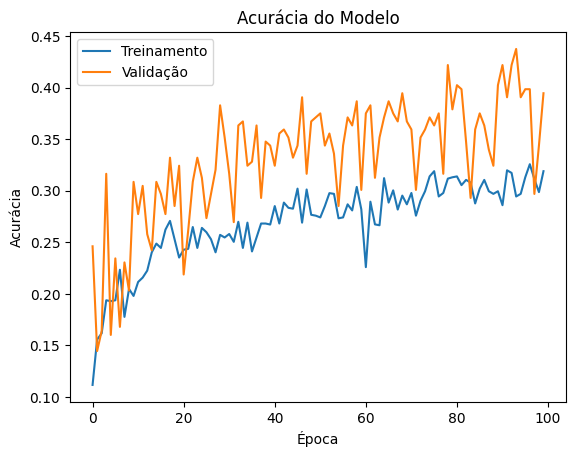

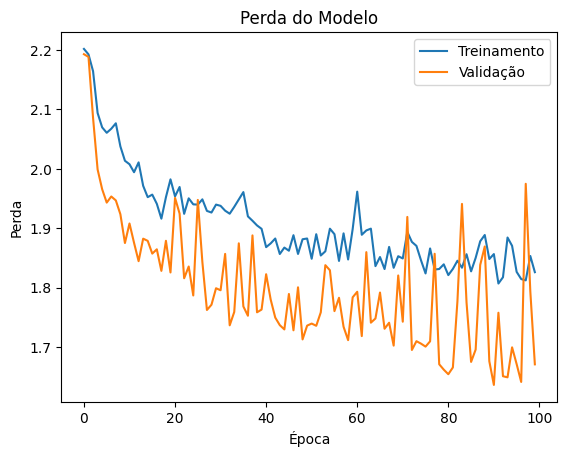

In [ ]:
# Plota a acurácia e a perda durante o treinamento
plt.plot(history_Resnet.history['accuracy'])
plt.plot(history_Resnet.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()

plt.plot(history_Resnet.history['loss'])
plt.plot(history_Resnet.history['val_loss'])
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.show()

In [ ]:
# Prever as classes do conjunto de teste
y_true = test_generator.classes
y_pred = np.argmax(Resnet_model.predict(test_generator), axis=-1)

2/2 [==============================] - 1s 333ms/step


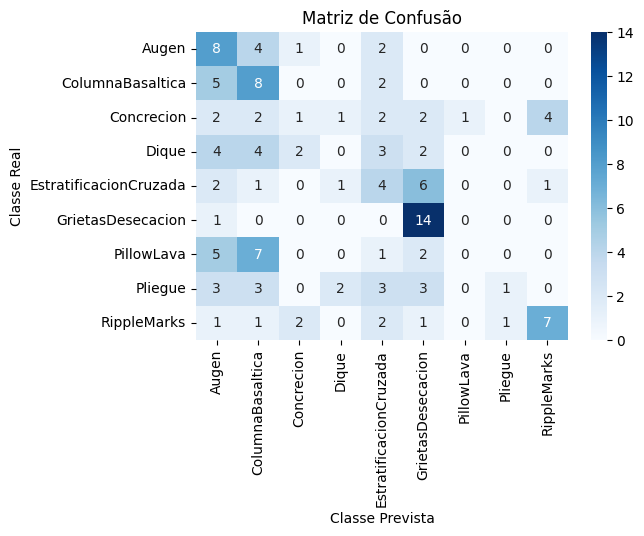

In [ ]:
# Calcula a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)

# Obtem os rótulos das classes
class_labels = list(test_generator.class_indices.keys())

# Plota a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

O resultado da matriz de confusão mostra que o modelo Resnet não generalizou nada bem, pois ocorreram predições erradas em todas classes. Sendo que em algumas classes, não foi possível classificar nenhuma estrutura.

In [ ]:
# Avalia o modelo Resnet50 no conjunto de teste
test_loss, test_accuracy, test_precision, test_recall, test_f1 = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

# Imprimi as métricas no conjunto de teste
print("Loss no conjunto de teste:", test_loss)
print("Acurácia no conjunto de teste:", test_accuracy)
print("Precisão no conjunto de teste:", test_precision)
print("Recall no conjunto de teste:", test_recall)
print("F1-score no conjunto de teste:", test_f1)

1/1 [==============================] - 0s 471ms/step - loss: 1.8224 - accuracy: 0.3125 - precision_2: 0.6522 - recall_3: 0.1172 - f1_score: 0.2470
Loss no conjunto de teste: 1.8224061727523804
Acurácia no conjunto de teste: 0.3125
Precisão no conjunto de teste: 0.6521739363670349
Recall no conjunto de teste: 0.1171875
F1-score no conjunto de teste: 0.2469514161348343


In [ ]:
# Salvar o modelo Resnet50
# Resnet_model.save('D:/Pessoal/Estudos_Pessoais/Pos_Graduacao/Clone_GitHub/Sprint_2/Deep_Learning/Modelos_MVP_Final/Resnet_model.h5')

O modelo Resnet50 mostrou um resultado muito baixo para o conjunto de teste com acuária de 31,25%. Esse foi o melhor resultado encontrado mesmo variando as configurações dos hiperparãemtros do modelo.

### Modelo InceptionV3

A configuração das camadas começa com a camada GlobalAveragePooling2D, passando para as camadas densas, começando com uma de 1024 neurônios e diminuindo até 32 neurônios para chegar próximo ao número de saída, 9 neurônios, representando cada uma das classes de estruturas, todas Dense. Ambas usando a função de reativação 'relu' no final de cada camada intermediária. Foi usado o Dropout com taxa de 0.35 também, que é uma técnica eficaz para combater o overfitting, fornecendo uma regularização interna durante o treinamento da rede neural. E para finalizar  as camadas, foi usado a função de reativação 'softmax', pois esse estudo se trata de uma classificação multiclasse.

In [ ]:
# Carrega o modelo InceptionV3 pré-treinado, usando os pesos da Imagenet e informado o tamanho das imagens.
Inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Congela todas as camadas do modelo base
for layer in Inception_model.layers:
    layer.trainable = False

In [ ]:
# Cria o modelo final, adicionando camadas personalizadas no topo do modelo base
Inception_model = tf.keras.models.Sequential([
    Inception_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# Exibe o resumo do modelo
Inception_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_11 (Dense)            (None, 512)               524800    
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                      

## 3.3 Treinamento do modelo InceptionV3
Nesse modelo foi usado o otimizador Adam; com uma taxa de aprendizado de 0.001; para a função de perda, foi escolhida a função Categorical_crossentropy; e como métrica foi específicado a Acurácia.

In [ ]:
# Compila o modelo InceptionV3 com o otimizador Adam configurado com a taxa de aprendizado e métricas
Inception_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',
                        metrics=['accuracy', Precision(), Recall(), f1_score])


In [ ]:
# Cria o callback para visualização das imagens durante o treinamento
tensorboard_callback = TensorBoard(log_dir='./logs')

In [ ]:
# NÃO recomendo ser executada, pois vai demorar muito o treinamento e o modelo já está treinado e salvo.

model = Inception_model  # Cria o modelo InceptionV3

Inception_model_metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1_score] # Usa as métricas desejadas

history_Inception = train_model(Inception_model, train_generator, validation_generator, Inception_model_metrics, epochs) # Treina o modelo

Epoch 1/100
10/10 [==============================] - 13s 1s/step - loss: 2.2362 - accuracy: 0.1438 - precision_4: 0.4167 - recall_5: 0.0042 - f1_score: 0.1214 - val_loss: 2.0426 - val_accuracy: 0.3008 - val_precision_4: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.1326
Epoch 2/100
10/10 [==============================] - 9s 844ms/step - loss: 1.9994 - accuracy: 0.2775 - precision_4: 1.0000 - recall_5: 0.0051 - f1_score: 0.1582 - val_loss: 1.8054 - val_accuracy: 0.3008 - val_precision_4: 0.5000 - val_recall_5: 0.0195 - val_f1_score: 0.2001
Epoch 3/100
10/10 [==============================] - 9s 946ms/step - loss: 1.7685 - accuracy: 0.3613 - precision_4: 0.8132 - recall_5: 0.0626 - f1_score: 0.2130 - val_loss: 1.4180 - val_accuracy: 0.5859 - val_precision_4: 0.9111 - val_recall_5: 0.1602 - val_f1_score: 0.3048
Epoch 4/100
10/10 [==============================] - 9s 934ms/step - loss: 1.5460 - accuracy: 0.4374 - precision_4: 0.7567 - recall_5: 0.1920 - f1_score: 0.3023 - val_lo

Visualização dos gráficos com resultados da acurácia e perda do modelo para o conjunto de treino e validação.

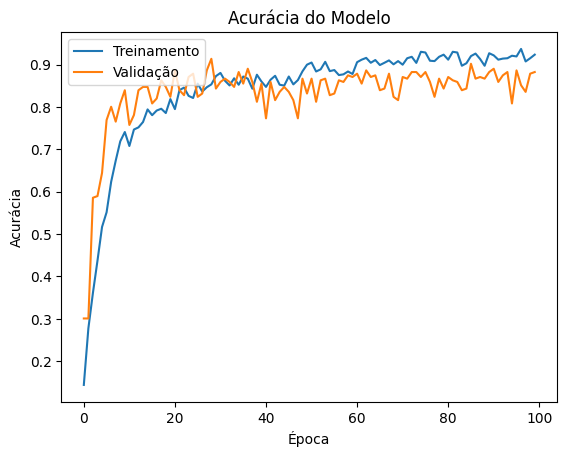

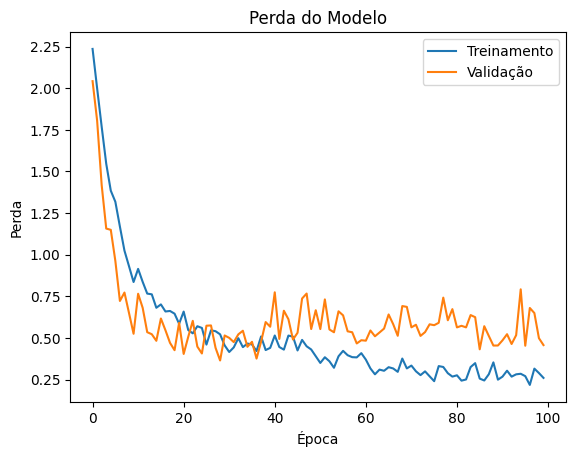

In [ ]:
# Plota a acurácia e a perda durante o treinamento
plt.plot(history_Inception.history['accuracy'])
plt.plot(history_Inception.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()

plt.plot(history_Inception.history['loss'])
plt.plot(history_Inception.history['val_loss'])
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.show()

In [ ]:
# Prever as classes do conjunto de teste
y_true = test_generator.classes
y_pred = np.argmax(Inception_model.predict(test_generator), axis=-1)

2/2 [==============================] - 1s 285ms/step


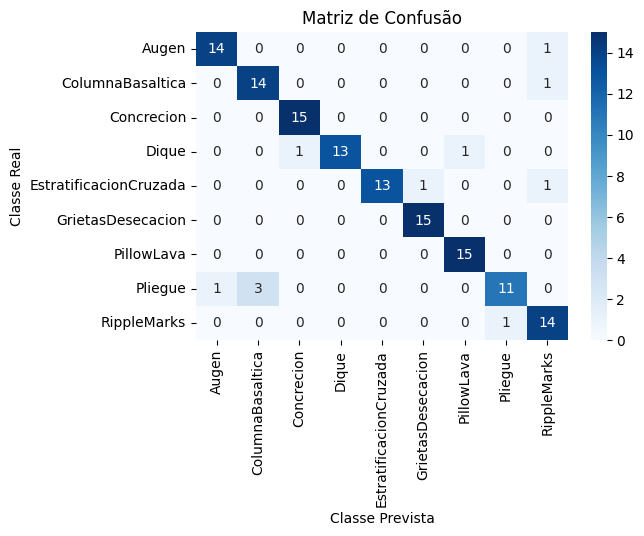

In [ ]:
# Calculaa a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)

# Obtem os rótulos das classes
class_labels = list(test_generator.class_indices.keys())

# Plota a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

O resultado da matriz de confusão mostra que o modelo Inception generalizou bastante bem, pois o modelo conseguiu realizar predições corretas em todas as classes, com destaque para a Estratificação Cruzada, Croncreção e Gretas de Ressecatamento, onde ele acertou todas. O ponto fraco ficou para as estruturas Pliegue, onde o modelo acertou aproximadamente 90% das predições.

In [ ]:
# Avalia o modelo InceptionV3 no conjunto de teste
test_loss, test_accuracy, test_precision, test_recall, test_f1 = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

# Imprimi as métricas no conjunto de teste
print("Loss no conjunto de teste:", test_loss)
print("Acurácia no conjunto de teste:", test_accuracy)
print("Precisão no conjunto de teste:", test_precision)
print("Recall no conjunto de teste:", test_recall)
print("F1-score no conjunto de teste:", test_f1)

1/1 [==============================] - 0s 355ms/step - loss: 0.4622 - accuracy: 0.9141 - precision_4: 0.9194 - recall_5: 0.8906 - f1_score: 0.8675
Loss no conjunto de teste: 0.46224093437194824
Acurácia no conjunto de teste: 0.9140625
Precisão no conjunto de teste: 0.9193547964096069
Recall no conjunto de teste: 0.890625
F1-score no conjunto de teste: 0.8675112128257751


O modelo InceptionV3 apresentou um bom resultado para o conjunto de teste com acuária de 91,93%. O resultado das demias metricas nos mostram que o modelo generalizou muito bem com os hiperparâmetros escolhidos. Destaque pode ser dado para a precisão de 92% desse modelo.
Esse foi o melhor resultado encontrado mesmo variando as configurações dos hiperparâmetros do modelo.

In [ ]:
# Salvar o modelo InceptionV3
# Inception_model.save('D:/Pessoal/Estudos_Pessoais/Pos_Graduacao/Clone_GitHub/Sprint_2/Deep_Learning/Modelos_MVP_Final/Inception_model.h5')

Visalizando algumas imagens do conjunto de validação com o modelo InceprionV3. Nessa visualização, será mostrado a classe e a predição do conjunto de validação.

4/4 [==============================] - 1s 37ms/step


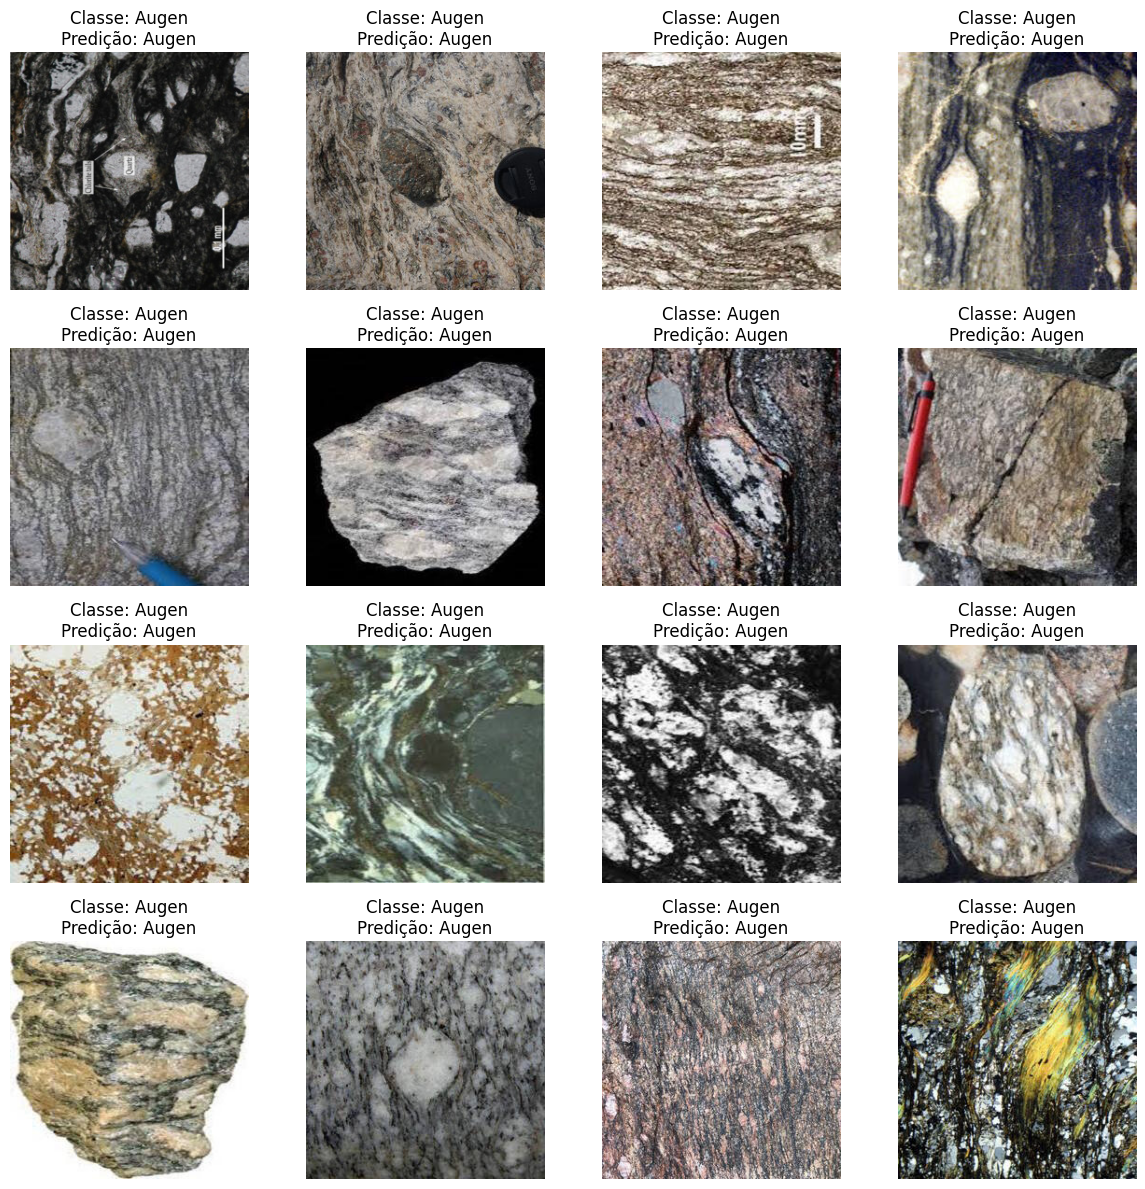

In [ ]:
# Visualiza algumas imagens do conjunto de validação e suas classes
class_names = sorted(validation_generator.class_indices.keys())
images, labels = next(validation_generator)
predicted_labels = Inception_model.predict(images)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img = images[i]
    label = np.argmax(labels[i])
    predicted_label = np.argmax(predicted_labels[i])

    ax.imshow(img)
    ax.set_title(f'Classe: {class_names[label]}\nPredição: {class_names[predicted_label]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


## 4. Execução do modelo com melhor resultado, InceptionV3,  no conjunto de teste

Visalizando algumas imagens do conjunto de teste com o modelo InceprionV3. Nessa visualziação já será mostrado a classe predita e a classe real.

In [ ]:
# Faz as previsões nas imagens de teste
predictions = Inception_model.predict(test_generator)

# Obtem as classes preditas para cada imagem
predicted_classes = np.argmax(predictions, axis=1)

# Obtem as classes reais para cada imagem
true_classes = test_generator.classes

# Obtem os rótulos das classes
class_labels = list(test_generator.class_indices.keys())

2/2 [==============================] - 0s 156ms/step


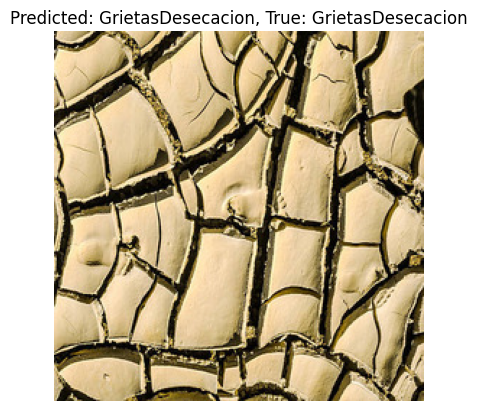

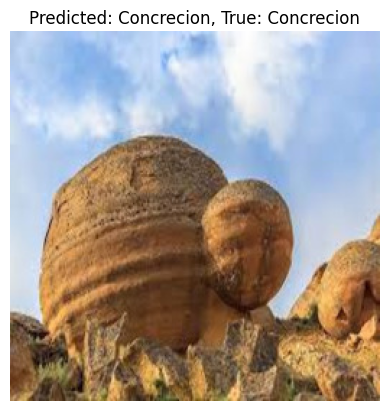

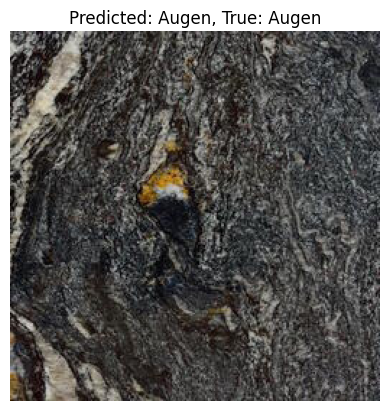

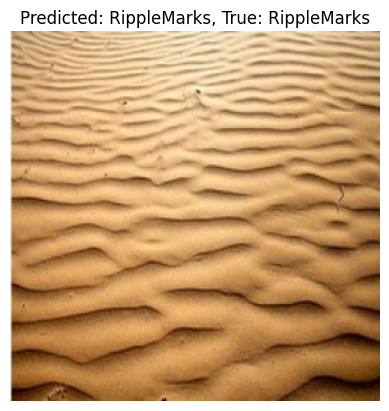

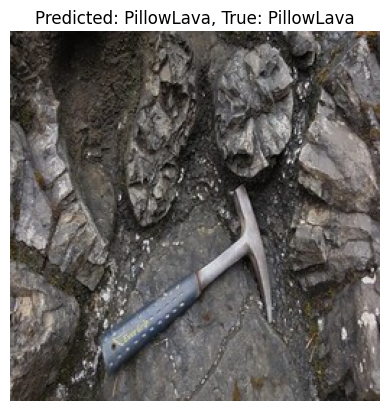

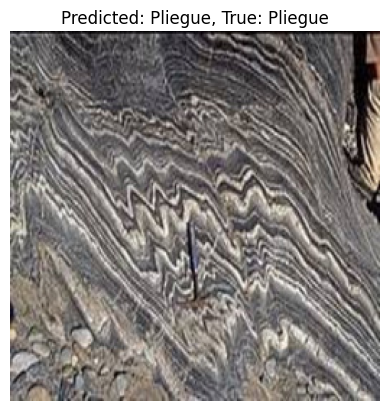

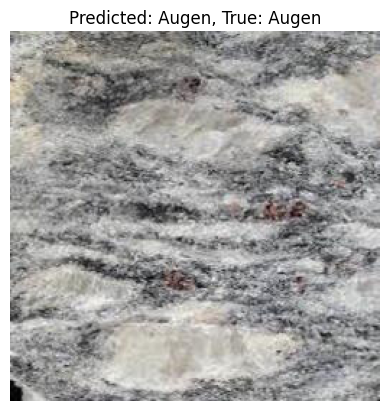

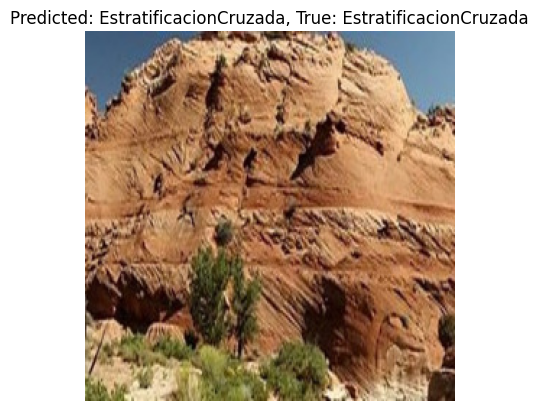

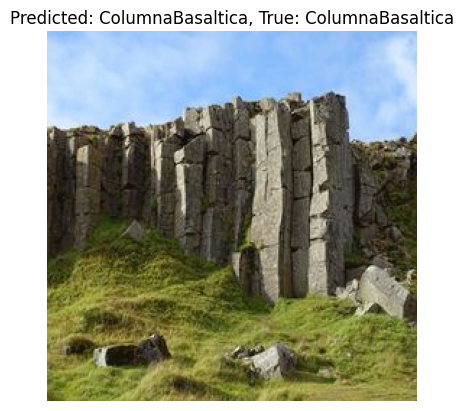

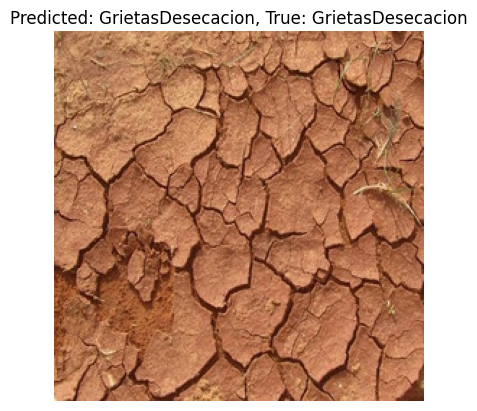

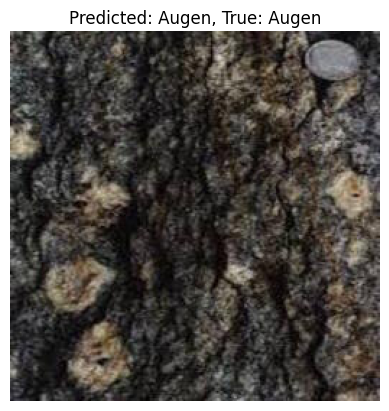

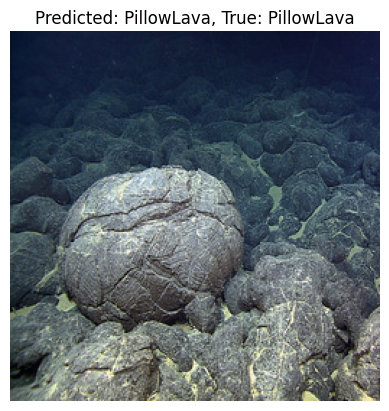

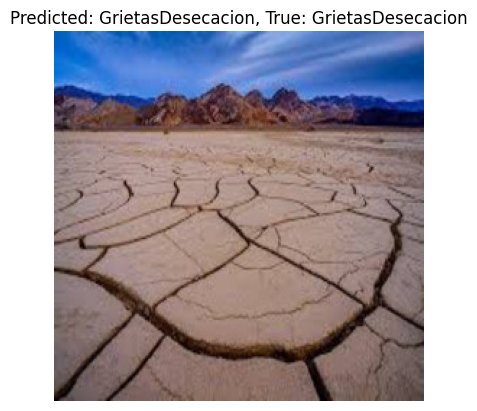

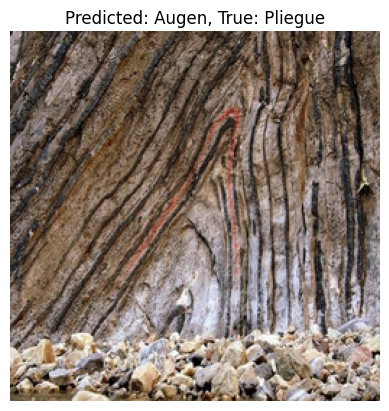

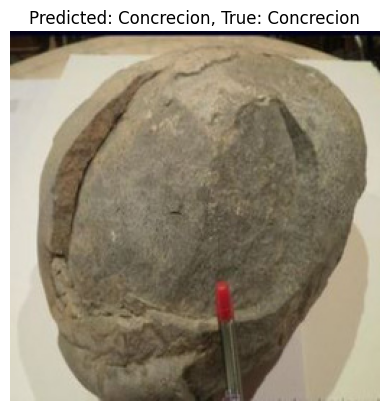

In [ ]:
# Mostra algumas imagens de teste com suas classes preditas e reais
num_images = 15  # Número de imagens para mostrar
sample_indices = np.random.choice(len(test_generator.filenames), num_images, replace=False)
for idx in sample_indices:
    image_path = os.path.join(diretorio_teste, test_generator.filenames[idx])
    image = Image.open(image_path)
    predicted_class = class_labels[predicted_classes[idx]]
    true_class = class_labels[true_classes[idx]]
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}, True: {true_class}')
    plt.axis('off')
    plt.show()

As imagens mostram que o modelo InceptionV3 generalizou muito bem para o conjunto de teste, onde praticamente todas as imagens amostradas estão com a predição correta.

## 5. Rodando o modelo CNN Profunda com Cross Validation para tentar melhorar o resultado.

Como o resultado do modelo da CNN Profunda ficou com um resutlado intermediário, vou treinar o modelo novamente com a validação cruzada para tentar obter um melhor resultado das métricas.

In [ ]:
# Cria a lista para armazenar as métricas de avaliação
accuracy_scores = []

Vou usar parâmetros diferentes do treino dos modelos para  diversificar mais os dados, assim o modelo terá uma quantidade maior de amostras.

Aqui novamente será usado o ImageDataGenerator para tratamento do dados de entrada..

In [ ]:
# Pré-processamento dos dados de entrada
train_datagen = ImageDataGenerator(rescale=1./255,  # Normalização
    rotation_range=30,  # Rotação aleatória de até 30 graus
    width_shift_range=0.3,  # Deslocamento horizontal aleatório
    height_shift_range=0.3,  # Deslocamento vertical aleatório
    shear_range=0.3,  # Cisalhamento aleatório
    zoom_range=0.3,  # Zoom aleatório
    horizontal_flip=True,  # Espelhamento horizontal aleatório
    fill_mode='nearest')  # Modo de preenchimento)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Carregar os dados de treinamento
train_data = train_datagen.flow_from_directory(diretorio_treino,
                                              target_size=(256, 256),
                                              batch_size=batch_size,
                                              class_mode='categorical')

# Carregar os dados de validação
val_data = val_datagen.flow_from_directory(diretorio_validacao,
                                          target_size=(256, 256),
                                          batch_size=batch_size,
                                          class_mode='categorical')

# Carregar os dados de teste
test_data = test_datagen.flow_from_directory(diretorio_teste,
                                            target_size=(256, 256),
                                            batch_size=batch_size,
                                            class_mode='categorical')

Found 1310 images belonging to 9 classes.
Found 360 images belonging to 9 classes.
Found 135 images belonging to 9 classes.


Para a CNN Profunda, o conjunto de dados será divido em 4 partes (ou dobras) para realizar a validação cruzada (parâmetro 'n_splits'). Cada dobra será usada como conjunto de teste uma vez, enquanto as demais dobras serão combinadas e usadas como conjunto de treinamento. Já o parâmetro 'shuffle', grante que antes de dividir os dados em dobras, eles serão embaralhados aleatoriamente. Será usada  uma semente aleatório com o valor 42.

Para este modelo foi será usado o otimizador Adam; com uma taxa de aprendizado de 0.001; para a função de perda, foi escolhida a função Categorical_crossentropy; e como métrica foi específicado a Acurácia.

### CNN Profunda com Cross Validation

In [ ]:
# Faz o treinamento do modelo CNN Profunda com validação cruzada
kf = KFold(n_splits=3, shuffle=True, random_state=42)
for train_index, val_index in kf.split(os.listdir(diretorio_treino)):
    # Obtem os dados de treinamento e validação para o fold atual
    train_data = train_data # Carregar os dados de treinamento usando os índices train_index
    val_data = val_data # Carregar os dados de validação usando os índices val_index

    # Compila o modelo
    #ccnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Treina o modelo
    # cnn_model.fit(train_data, epochs=epochs, batch_size=batch_size, validation_data=val_data)

    # Avalia o modelo nos dados de validação
    # val_loss, val_accuracy = cnn_model.evaluate(val_data)
    # accuracy_scores.append(val_accuracy)

# Compila o modelo CNN com o otimizador Adam configurado com a taxa de aprendizado e métricas
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',
                  metrics=['accuracy', Recall(), f1_score])


In [ ]:
# NÃO recomendo ser executada, pois vai demorar muito o treinamento e o modelo já está treinado e salvo.

model = cnn_model  # Cria o modelo deep CNN com Validação Cruzada

cnn_model_metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1_score] # Usa as métricas desejadas

history_cnn = train_model(cnn_model, train_generator, validation_generator, cnn_model_metrics, epochs) # Treina o modelo

Epoch 1/100
10/10 [==============================] - 10s 903ms/step - loss: 1.4217 - accuracy: 0.5305 - precision_5: 0.6843 - recall_7: 0.3942 - f1_score: 0.4384 - val_loss: 1.1598 - val_accuracy: 0.6250 - val_precision_5: 0.8547 - val_recall_7: 0.3906 - val_f1_score: 0.4690
Epoch 2/100
10/10 [==============================] - 9s 802ms/step - loss: 1.1425 - accuracy: 0.5846 - precision_5: 0.8024 - recall_7: 0.3985 - f1_score: 0.4462 - val_loss: 0.9740 - val_accuracy: 0.6836 - val_precision_5: 0.8239 - val_recall_7: 0.5117 - val_f1_score: 0.5407
Epoch 3/100
10/10 [==============================] - 8s 823ms/step - loss: 1.0451 - accuracy: 0.6303 - precision_5: 0.8156 - recall_7: 0.4788 - f1_score: 0.4970 - val_loss: 1.0827 - val_accuracy: 0.6445 - val_precision_5: 0.7650 - val_recall_7: 0.5469 - val_f1_score: 0.5457
Epoch 4/100
10/10 [==============================] - 8s 816ms/step - loss: 0.9488 - accuracy: 0.6692 - precision_5: 0.8287 - recall_7: 0.5034 - f1_score: 0.5295 - val_loss: 1

In [ ]:
# Avalia o modelo CNN Profunda no conjunto de teste
test_loss, test_accuracy, test_precision, test_recall, test_f1 = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

# Imprimir as métricas no conjunto de teste
print("Loss no conjunto de teste:", test_loss)
print("Acurácia no conjunto de teste:", test_accuracy)
print("Precisão no conjunto de teste:", test_precision)
print("Recall no conjunto de teste:", test_recall)
print("F1-score no conjunto de teste:", test_f1)

1/1 [==============================] - 0s 227ms/step - loss: 0.9343 - accuracy: 0.7500 - precision_5: 0.8108 - recall_7: 0.7031 - f1_score: 0.6826
Loss no conjunto de teste: 0.9342824220657349
Acurácia no conjunto de teste: 0.75
Precisão no conjunto de teste: 0.8108108043670654
Recall no conjunto de teste: 0.703125
F1-score no conjunto de teste: 0.6826361417770386


O valor da acurácia para o modelo CNN Profundo aumentou consideravelmente com a execução da validação cruzada, saindo de 63,54% para 75,00%. Isso nos dá um ganho de
aproximadamente 18%.

In [ ]:
# Salvar o modelo Deep CNN
# cnn_model.save('D:/Pessoal/Estudos_Pessoais/Pos_Graduacao/Clone_GitHub/Sprint_2/Deep_Learning/Modelos_MVP_Final/Depp_CNN_Cross_Validation.h5')

## 6. Conclusões

Após o treino dos 3 modelos e a verificação da porcentagem das predições corretas no conjunto de teste, podemos avaliar que:
- O modelo CNN apresentou um resultado mediano, todas as métricas empregados no treino mostraram que o modelo obteve em torno de 65% de predições corretas. Esse resultado melhor com a execução da Valida Cruzada aproximadamente 10%.

- O modelo Resnet50 apresentou o pior resultado entre os 3 modelo, conseguindo predições corretas em torno de 25% das amostras.

- O modelo InceptionV3 apresentou o melhor resultado entre os 3 modelos, incluindo o resultado da Validação Cruzada no modelo CNN. O modelo obteve aproximadamente 85% de predições corretas (já obtive 92% de acurácia, porém, como o conjunto de teste não é muito grande, esse resultado muda muito). Não achei necessário tentar melhorar esse resultado com a VAlidação Curzada, pois o custo de processamento é bastante alto.

Esse estudo mostra que o uso de aprendizado de máquinas, tem um grande potencial para serem aplicados em classificação de estruturas geológicas para auxiliar profissionais e estudantes de Geologia e Ciências Naturais.